In [1]:
from skimage.transform import resize
from ast import literal_eval as make_tuple
import os
import numpy as np
from pathlib import Path
import nibabel as nib
from tensorflow.keras import backend as K
import tensorflow as tf
import nibabel as nib
import cv2
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.layers import *
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import directed_hausdorff
import segmentation_models as sm
import seaborn as sns

Segmentation Models: using `keras` framework.


In [2]:
%matplotlib inline
plt.figure(figsize=(256, 256))

<Figure size 18432x18432 with 0 Axes>

<Figure size 18432x18432 with 0 Axes>

# Avaliando métricas

In [4]:
dfs = []
metrics_path = r'C:\Users\duccl\projects\fei\wvc\metrics'
for path in Path(metrics_path).rglob('*.csv'):
    net_df = pd.read_csv(str(path))
    net_df['net'] = path.name.split('_metrics')[0]
    dfs.append(net_df)

In [5]:
df = pd.concat(dfs,ignore_index=True)

In [6]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df.head()

,dice,hausdorff,iou,net
0,0.980725,0.000018,0.326925,unet_backbone_resnet34_jaccard_loss_relu_defau...
1,0.991306,6.408988,0.598473,unet_backbone_resnet34_jaccard_loss_relu_defau...
2,0.995169,5.026532,0.682777,unet_backbone_resnet34_jaccard_loss_relu_defau...
3,0.992836,5.580591,0.695471,unet_backbone_resnet34_jaccard_loss_relu_defau...
4,0.993920,5.231012,0.704220,unet_backbone_resnet34_jaccard_loss_relu_defau...


In [8]:
df.groupby('net').mean()

,dice,hausdorff,iou
net,,,
unet_backbone_resnet34_jaccard_loss_relu_default_acdc_wvc,0.995150,4.529609,0.841357
unet_backbone_resnet34_jaccard_loss_relu_qsigmoid_acdc_wvc,0.992254,5.193237,0.774559
unet_bce_jaccard_loss_relu_default_acdc_wvc,0.995981,4.286236,0.885057
unet_bce_jaccard_loss_relu_qsigmoid_acdc_wvc,0.955682,7.063819,0.478615
unet_dice_loss_relu_default_acdc_wvc,0.993963,4.952980,0.809726
unet_dice_loss_relu_qsigmoid_acdc_wvc,0.990942,5.421888,0.744004


In [9]:
df.groupby('net').max()

,dice,hausdorff,iou
net,,,
unet_backbone_resnet34_jaccard_loss_relu_default_acdc_wvc,0.999994,12.220193,0.850446
unet_backbone_resnet34_jaccard_loss_relu_qsigmoid_acdc_wvc,0.999991,10.386281,0.868659
unet_bce_jaccard_loss_relu_default_acdc_wvc,0.999997,9.411953,0.895571
unet_bce_jaccard_loss_relu_qsigmoid_acdc_wvc,0.992874,13.134439,0.591130
unet_dice_loss_relu_default_acdc_wvc,0.999993,13.991405,0.871955
unet_dice_loss_relu_qsigmoid_acdc_wvc,0.999983,13.130133,0.763645


In [10]:
df.groupby('net').min()

,dice,hausdorff,iou
net,,,
unet_backbone_resnet34_jaccard_loss_relu_default_acdc_wvc,0.971675,0.000015,0.326925
unet_backbone_resnet34_jaccard_loss_relu_qsigmoid_acdc_wvc,0.969421,0.000043,0.762588
unet_bce_jaccard_loss_relu_default_acdc_wvc,0.979989,0.000022,0.818088
unet_bce_jaccard_loss_relu_qsigmoid_acdc_wvc,0.865689,0.000018,0.438048
unet_dice_loss_relu_default_acdc_wvc,0.970754,0.000016,0.680082
unet_dice_loss_relu_qsigmoid_acdc_wvc,0.961317,0.000076,0.345363


In [11]:
nets = list(df['net'].unique())
df['net_as_categorical'] = df['net'].apply(lambda n: nets.index(n))

In [12]:
nets

['unet_backbone_resnet34_jaccard_loss_relu_default_acdc_wvc',
 'unet_backbone_resnet34_jaccard_loss_relu_qsigmoid_acdc_wvc',
 'unet_bce_jaccard_loss_relu_default_acdc_wvc',
 'unet_bce_jaccard_loss_relu_qsigmoid_acdc_wvc',
 'unet_dice_loss_relu_default_acdc_wvc',
 'unet_dice_loss_relu_qsigmoid_acdc_wvc']

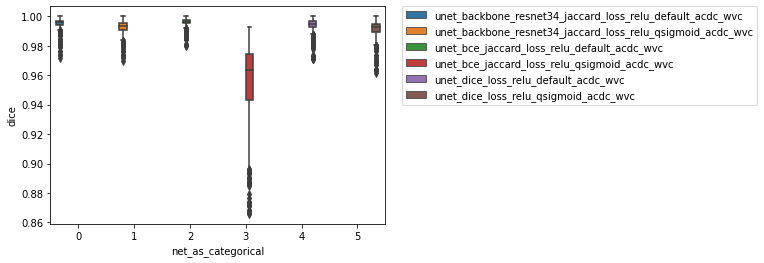

In [28]:
sns.boxplot(data=df,x='net_as_categorical',y='dice',hue='net')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

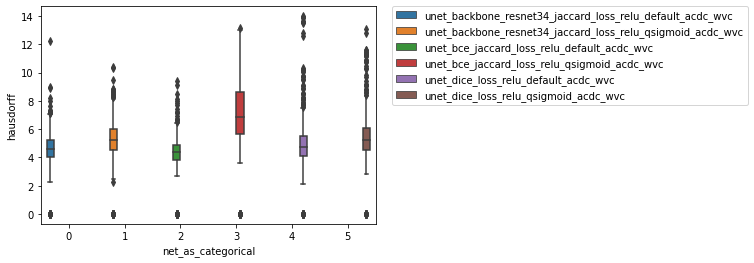

In [29]:
sns.boxplot(data=df,x='net_as_categorical',y='hausdorff',hue='net')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

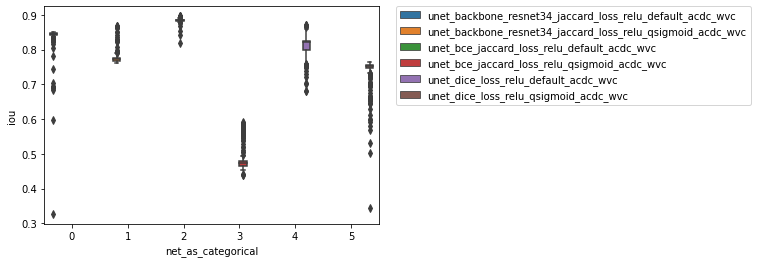

In [30]:
sns.boxplot(data=df,x='net_as_categorical',y='iou',hue='net')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Avaliando Historico de treino

In [16]:
dfs_history = []
history_path = r'C:\Users\duccl\projects\fei\wvc\history'
for path in Path(history_path).rglob('*.csv'):
    net_df = pd.read_csv(str(path))
    net_df['net'] = path.name.split('_history')[0]
    dfs_history.append(net_df)
df_history = pd.concat(dfs_history,ignore_index=True)
df_history.drop('Unnamed: 0',axis=1,inplace=True)

In [17]:
df_history.head()

,loss,custom_mean_iou,f1-score,val_loss,val_custom_mean_iou,val_f1-score,net
0,0.818289,0.261872,0.249424,0.993321,0.006678,0.013219,unet_backbone_resnet34_jaccard_loss_relu_defau...
1,0.686387,0.462081,0.378212,0.988259,0.011049,0.023049,unet_backbone_resnet34_jaccard_loss_relu_defau...
2,0.527444,0.603025,0.570990,0.925593,0.086410,0.125080,unet_backbone_resnet34_jaccard_loss_relu_defau...
3,0.369331,0.689027,0.741469,0.792276,0.210142,0.274589,unet_backbone_resnet34_jaccard_loss_relu_defau...
4,0.292856,0.730865,0.807936,0.795674,0.207631,0.265134,unet_backbone_resnet34_jaccard_loss_relu_defau...


In [18]:
df_history.groupby('net').max()

,loss,custom_mean_iou,f1-score,val_loss,val_custom_mean_iou,val_f1-score
net,,,,,,
unet_backbone_resnet34_jaccard_loss_relu_default_acdc_wvc,0.818289,0.924246,0.957709,0.993321,0.854357,0.915677
unet_backbone_resnet34_jaccard_loss_relu_qsigmoid_acdc_wvc,0.789414,0.922682,0.957024,0.994918,0.781969,0.864012
unet_bce_jaccard_loss_relu_default_acdc_wvc,1.116048,0.911567,0.948705,1.502022,0.884719,0.929482
unet_bce_jaccard_loss_relu_qsigmoid_acdc_wvc,1.126398,0.669307,0.757410,2.747895,0.478515,0.575247
unet_dice_loss_relu_default_acdc_wvc,0.675783,0.894343,0.939193,0.979551,0.848018,0.909899
unet_dice_loss_relu_qsigmoid_acdc_wvc,0.694841,0.838214,0.903426,0.960000,0.760150,0.846907


In [19]:
df_history.groupby('net').mean()

,loss,custom_mean_iou,f1-score,val_loss,val_custom_mean_iou,val_f1-score
net,,,,,,
unet_backbone_resnet34_jaccard_loss_relu_default_acdc_wvc,0.163724,0.849161,0.892585,0.311916,0.692019,0.760125
unet_backbone_resnet34_jaccard_loss_relu_qsigmoid_acdc_wvc,0.180038,0.830532,0.880683,0.470945,0.531826,0.605211
unet_bce_jaccard_loss_relu_default_acdc_wvc,0.238297,0.799022,0.854672,0.382201,0.701075,0.764279
unet_bce_jaccard_loss_relu_qsigmoid_acdc_wvc,0.520193,0.550613,0.627473,0.857491,0.335569,0.348316
unet_dice_loss_relu_default_acdc_wvc,0.155915,0.778064,0.844101,0.267898,0.663397,0.732102
unet_dice_loss_relu_qsigmoid_acdc_wvc,0.251832,0.662416,0.748025,0.421783,0.505638,0.578217


In [20]:
nets = list(df_history['net'].unique())
df_history['net_as_categorical'] = df_history['net'].apply(lambda n: nets.index(n))

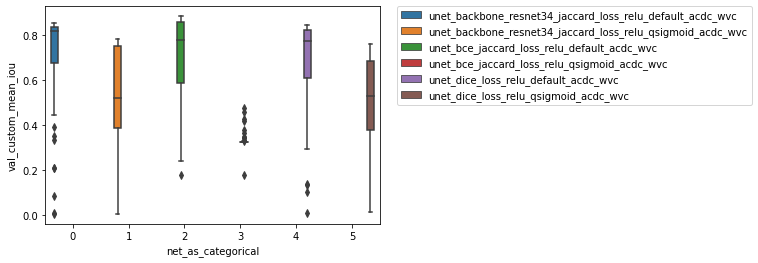

In [31]:
sns.boxplot(data=df_history,x='net_as_categorical',y='val_custom_mean_iou',hue='net')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

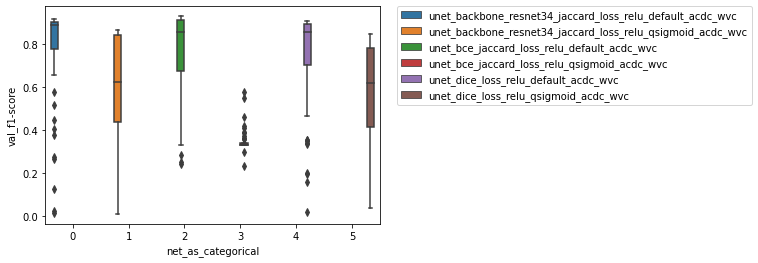

In [32]:
sns.boxplot(data=df_history,x='net_as_categorical',y='val_f1-score',hue='net')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

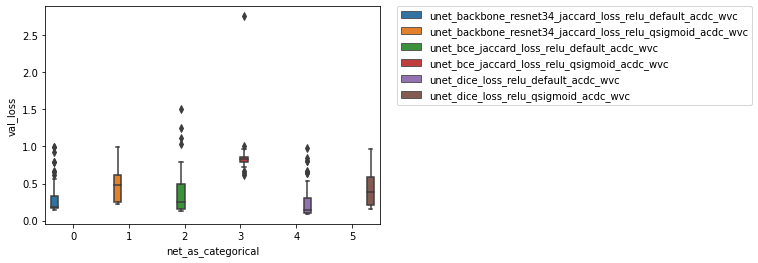

In [33]:
sns.boxplot(data=df_history,x='net_as_categorical',y='val_loss',hue='net')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'Loss X Epochs')

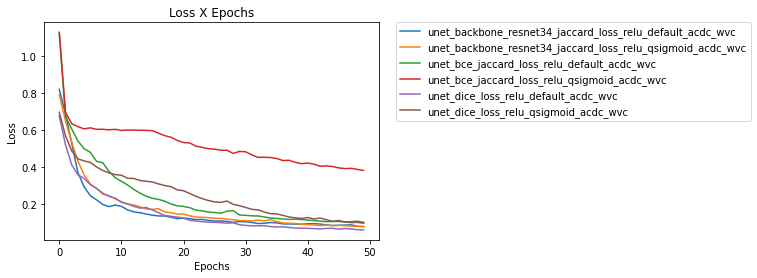

In [54]:
nets = df_history['net'].unique()
for net in nets:
    plt.plot(np.arange(50),df_history[df_history['net'] == net].loss)    
plt.legend(nets,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss X Epochs')

Text(0.5, 1.0, 'Mean IOU X Epochs')

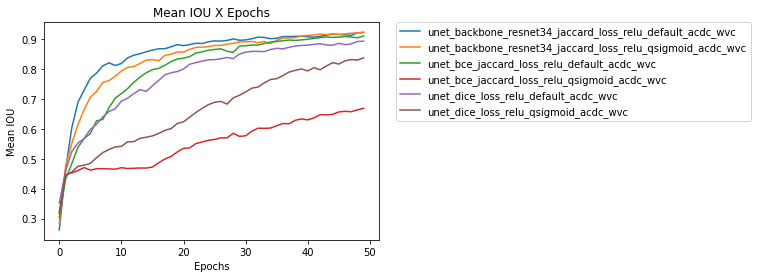

In [60]:
nets = df_history['net'].unique()
for net in nets:
    plt.plot(np.arange(50),df_history[df_history['net'] == net]['custom_mean_iou'])    
plt.legend(nets,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Mean IOU')
plt.title('Mean IOU X Epochs')

Text(0.5, 1.0, 'F1-Score X Epochs')

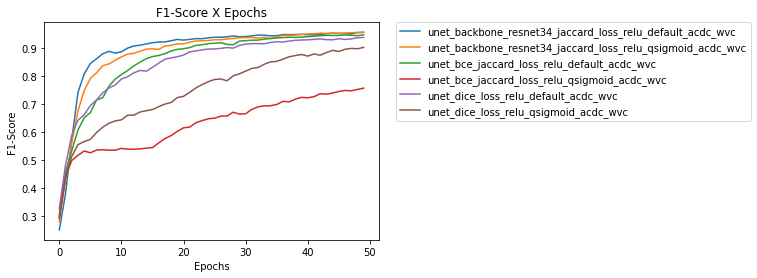

In [62]:
nets = df_history['net'].unique()
for net in nets:
    plt.plot(np.arange(50),df_history[df_history['net'] == net]['f1-score'])    
plt.legend(nets,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score X Epochs')

Text(0.5, 1.0, 'Validation Loss X Epochs')

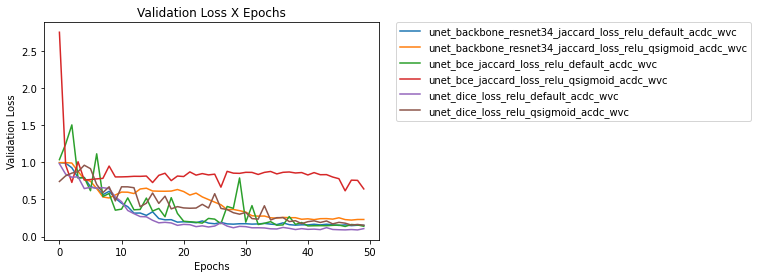

In [56]:
nets = df_history['net'].unique()
for net in nets:
    plt.plot(np.arange(50),df_history[df_history['net'] == net]['val_loss'])    
plt.legend(nets,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss X Epochs')

Text(0.5, 1.0, 'Validation Mean IOU X Epochs')

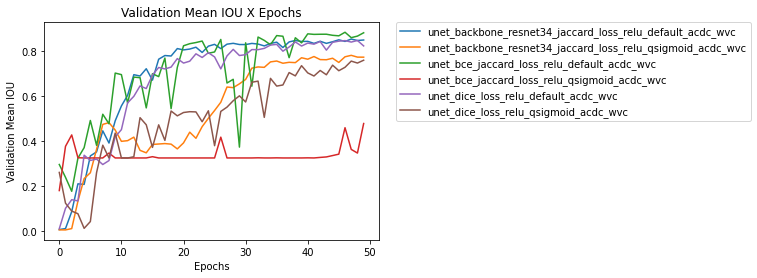

In [58]:
nets = df_history['net'].unique()
for net in nets:
    plt.plot(np.arange(50),df_history[df_history['net'] == net]['val_custom_mean_iou'])    
plt.legend(nets,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Validation Mean IOU')
plt.title('Validation Mean IOU X Epochs')

Text(0.5, 1.0, 'Validation F1-Score X Epochs')

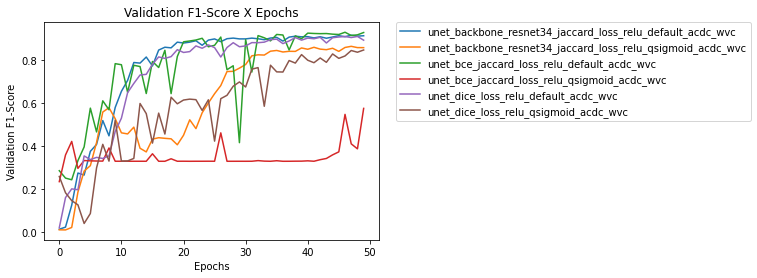

In [59]:
nets = df_history['net'].unique()
for net in nets:
    plt.plot(np.arange(50),df_history[df_history['net'] == net]['val_f1-score'])    
plt.legend(nets,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epochs')
plt.ylabel('Validation F1-Score')
plt.title('Validation F1-Score X Epochs')